In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

## our dataset

we create a function of two variables x1 and x2, that outputs one number

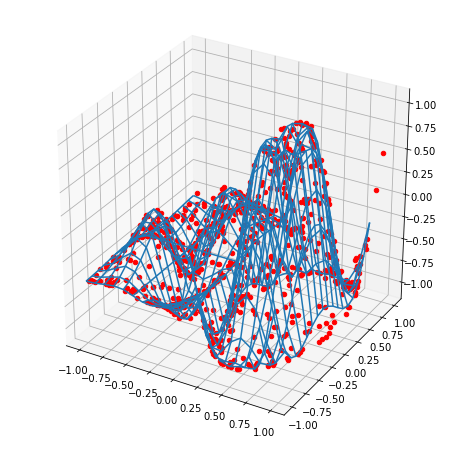

In [125]:
def func(x1_,x2_):
    if x1_ < 0:
        x1 = 2*( (x1_+1)*2-1 )
        x2 = 2*x2_
        return 3*x1*x2*np.exp(-x1**2-x2**2)-0.5
    else:
        x1 = 5*( x1_*2-1 )
        x2 = 5*x2_
        return np.sin(np.sqrt(x1**2+x2**2))

X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

Y = np.zeros(X1.shape)
for i, x1_i in enumerate(X1_):
    for j, x2_i in enumerate(X2_):
        Y[j][i] = func(x1_i,x2_i)

x1x2 = np.random.rand(10000,2)*2.0-1.0

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

for samp in x1x2[:800]:
    
    ax.scatter(samp[0],samp[1],func(samp[0],samp[1]),c='r')



plt.show()

## create our training dataset in the form of input X and output y

In [7]:
df = pd.DataFrame(x1x2,columns=['x1','x2'])

df['X'] = [ np.array([x1,x2]) for  x1,x2 in zip(df.x1,df.x2)  ]
df['y'] = [ func(x1,x2) for x1,x2 in zip(df.x1,df.x2) ]

df = df.drop('x1',axis=1).drop('x2',axis=1)
df

,X,y
0,"[0.16406935146995139, -0.8484286929313232]",-0.765629
1,"[-0.8429911743142644, 0.6011291001910684]",-0.677523
2,"[-0.20460292934526025, -0.7196302232881893]",-0.659132
3,"[-0.7312008179454041, -0.6970601744442468]",-0.264520
4,"[-0.297451436651311, 0.7037723422675497]",-0.255275
...,...,...
9995,"[0.3885348485788942, 0.16145050153076435]",0.981138
9996,"[0.7819357678376737, 0.7499092002710956]",-0.999777
9997,"[0.9962882715598564, 0.839037872526901]",0.213603
9998,"[0.5079512005391511, -0.8106790122176821]",-0.791086


# Data handling 

### Tensors, DataSets, and DataLoaders

here we create a 1d tensor of shape (2)

In [61]:
x = torch.FloatTensor([3.8,4.2])


print('x.shape ',x.shape)
print('x[0] ', x[0])
print('x[1] ', x[1])

x.shape  torch.Size([2])
x[0]  tensor(3.8000)
x[1]  tensor(4.2000)


### lets create our dataset for training

In [63]:
len_train = 9000

x_full = torch.FloatTensor(df.X)
y_full = torch.FloatTensor(df.y).view(len(df),1)

x_train = x_full[:len_train]
y_train = y_full[:len_train]

x_valid = x_full[len_train:]
y_valid = y_full[len_train:]

In [64]:
x_train.shape

torch.Size([9000, 2])

In [65]:
y_train.shape

torch.Size([9000, 1])

## A Dataset object is basically a wrapper around our (x,y) pairs - if we ask for a particular index it will give us a single (x,y), we will learn to write custom dataset objects later in the course

In [67]:
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

In [68]:
train_ds[53]

(tensor([-0.9866, -0.0031]), tensor([-0.4992]))

## now lets create a dataloader

In [69]:
dataloader = DataLoader(train_ds,batch_size=10)

## a dataloader is used to batch together items for training, it returns multiple (x,y) every time you loop over it

In [70]:
for x,y in dataloader:
    break
    
print(x.shape,y.shape)

torch.Size([10, 2]) torch.Size([10, 1])


# Model

### how to build a neural network?

## pytorch basics: a layer

a layer takes input and gives some output, in this case, it takes in a tensor of shape (2) and outputs tensor of shape (10)

In [72]:
my_first_layer = nn.Linear(2,10)

x = torch.FloatTensor([3.8,4.2])

my_first_layer(x)

tensor([ 4.3041, -2.0207,  0.6025,  4.2401,  1.9168,  2.4985, -0.9517,  2.5467,
         1.1979,  5.8003], grad_fn=<AddBackward0>)

## an activation function

this object can take a torch tensor of arbitrary size, and apply some function to each of it's elements

we can chain these objects together, so we input x to our layer, and input the layer output to our activation function

In [10]:
activation1 = nn.ReLU()

activation1( my_first_layer(x) )

tensor([2.1916, 2.4688, 4.7077, 0.6128, 3.8469, 0.0000, 3.0789, 2.5896, 1.8656,
        1.4932], grad_fn=<ReluBackward0>)

## we can create another layer, and put everything together

this layer will take as input 10 numbers, and output 1 number
we created a function that takes us from two numbers to one number, just like our dataset requires

In [11]:
layer2 = nn.Linear(10,1)

layer2(activation1( my_first_layer(x) ))

tensor([-0.2914], grad_fn=<AddBackward0>)

## a final activation function

our function output is between -1 and 1, so we can use the Tanh activation on the final output to make sure the output is also in that range

In [12]:
activation2 = nn.Tanh()

activation2(layer2(activation1( my_first_layer(x) )))

tensor([-0.2834], grad_fn=<TanhBackward>)

## important comment about batches and layers

notice that we showed layers taking a single input, but they are designed to take multiple inputs and return multiple outputs

In [73]:
x = torch.FloatTensor([[0.2,0.3],[0.4,0.6],[0.8,-0.2]])

print(' x.shape ',x.shape) #torch.Size([3, 2])

my_first_layer = nn.Linear(2,10)

out = my_first_layer(x)

print('out shape ',out.shape)

 x.shape  torch.Size([3, 2])
out shape  torch.Size([3, 10])


## what is in these layers?

these are "linear" layers
the first layer we created went from 2 numbers to 10 numbers
inside there is a 10x2 matrix and a vector of size 10
the values of these elements is randomly selected when we create the layer

In [74]:
for p in my_first_layer.parameters():
    print(p)
    print(p.shape)
    print('----------')

Parameter containing:
tensor([[ 0.4798,  0.1629],
        [-0.0457,  0.1970],
        [-0.6071, -0.5628],
        [-0.0384,  0.1178],
        [-0.6895,  0.5137],
        [-0.6787,  0.5289],
        [ 0.0096, -0.2525],
        [ 0.6601, -0.6735],
        [ 0.1286, -0.6178],
        [-0.4475,  0.1895]], requires_grad=True)
torch.Size([10, 2])
----------
Parameter containing:
tensor([-3.5061e-01, -6.8241e-01, -1.3509e-01,  5.6473e-01, -3.8580e-01,
        -3.9427e-01,  2.4992e-04, -1.2358e-01, -6.1092e-01, -3.3038e-01],
       requires_grad=True)
torch.Size([10])
----------


## creating a neural network object

in order to "train" our weights pytorch has a special structure for "models"
let's put our building blocks into a object like this:

In [90]:
#this code defines the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(2,10)
        self.layer2 = nn.Linear(10,1)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.Tanh()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        out = self.activation2(out)
        
        return out
    

In [100]:
#and this code creates a neural net based on the definition above
net = Net()

In [101]:
x

tensor([[-0.5602,  0.2967],
        [-0.5242, -0.0068],
        [ 0.9733,  0.7193],
        [-0.1260, -0.1236],
        [ 0.1592,  0.3491],
        [ 0.6170,  0.8948],
        [ 0.3296,  0.3266],
        [ 0.3841,  0.6965],
        [ 0.8772, -0.4787],
        [-0.0494,  0.3211]])

In [102]:
net(x)

tensor([[-0.2498],
        [-0.2233],
        [-0.4978],
        [-0.2817],
        [-0.3935],
        [-0.4782],
        [-0.4086],
        [-0.4420],
        [-0.3642],
        [-0.3673]], grad_fn=<TanhBackward>)

## let's see what our neural network predicts with totally random weights

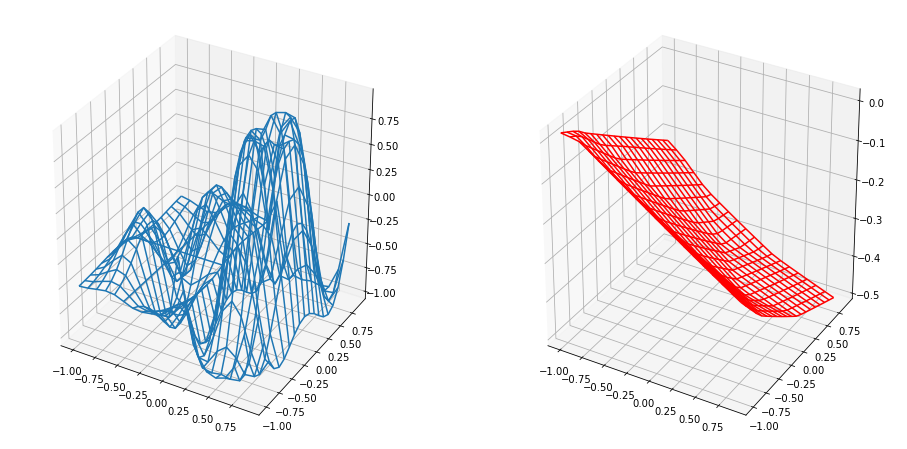

In [103]:


X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

# Training 

## define our loss function

In [104]:
loss_func = nn.MSELoss()

### this object, the loss function can compare our target y, and our predicted y, and return a number

if y is "closer" to y', the value of the loss is lower

In [105]:
target = torch.tensor([4.1])
prediction = torch.tensor([3.2])
loss_func(target,prediction)

tensor(0.8100)

### now we create "the optimizer"

we will talk about this in more depth later,

In [106]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.0005) 

and we run a "training loop" where the network looks at some batches of examples,
and adjusts its parameters - the goal is to lower the loss value

In [107]:
from tqdm.notebook import tqdm

for epoch in tqdm( range(20) ):
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = net(x)
        loss = loss_func(y,output)
        
        loss.backward()  
        optimizer.step()

## let's see what the network predicts now

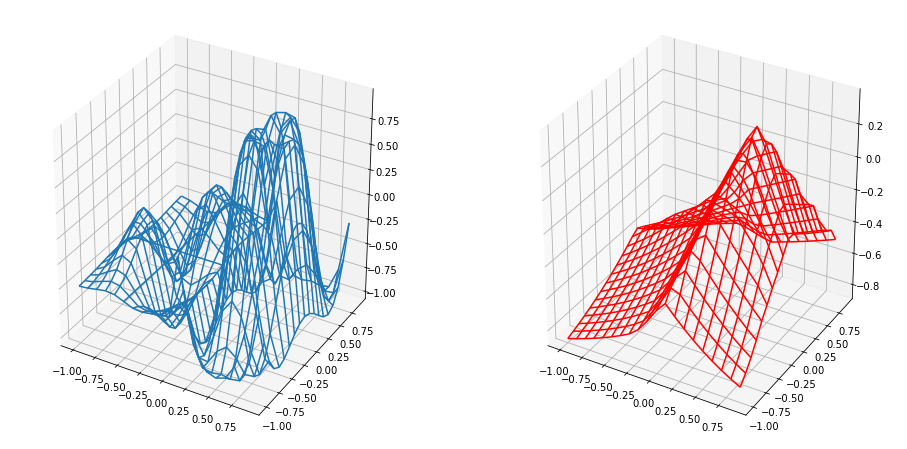

In [108]:
X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

## let's try a neural network with a few more parameters

our last network picked up the general features of our target function, but it's not perfect

In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(2,100)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(100,50)
        self.layer3 = nn.Linear(50,10)
        self.layer4 = nn.Linear(10,1)
        self.activation2 = nn.Tanh()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        out = self.activation1(out)
        out = self.layer3(out)
        out = self.activation1(out)
        out = self.layer4(out)
        out = self.activation2(out)
        
        return out
    
net = Net()

In [110]:
sum([len(p.view(-1)) for p in net.parameters()])


5871

In [114]:
net = Net()

In [115]:
optimizer = optim.Adam(net.parameters(), lr=0.01) 

In [116]:
from tqdm.notebook import tqdm

for epoch in tqdm( range(20) ):
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = net(x)
        loss = loss_func(y,output)
        
        loss.backward()  
        optimizer.step()

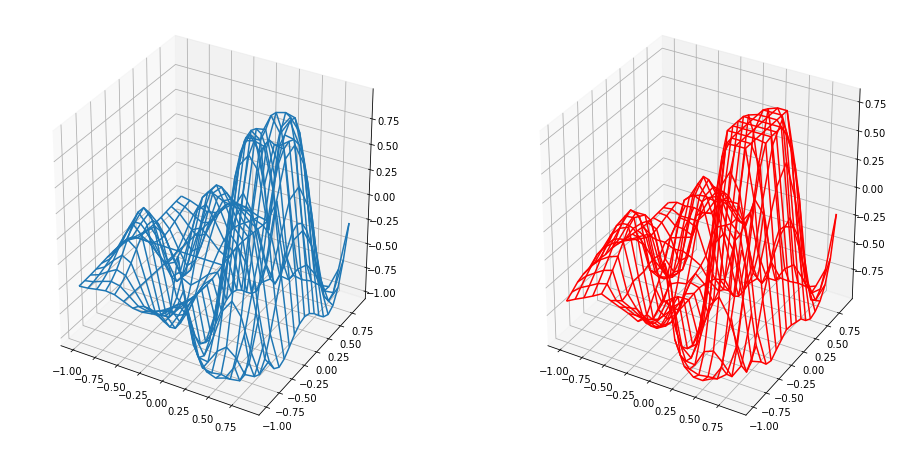

In [117]:

X1_ = np.arange(-1, 1, 0.1)
X2_ = np.arange(-1, 1, 0.1)
X1, X2 = np.meshgrid(X1_, X2_)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X1, X2, Y)

ax2 = fig.add_subplot(1,2,2,projection='3d')    
x1 = np.arange(-1, 1, 0.1)
x2 = np.arange(-1, 1, 0.1)
Yprime = np.zeros(Y.shape)
for i, x1_i in enumerate(x1):
    for j, x2_i in enumerate(x2):
        input_i = torch.FloatTensor([x1_i,x2_i])
        y_i = net(input_i)
        
        Yprime[j][i] = y_i
ax2.plot_wireframe(X1,X2,Yprime,color='r')


plt.show()

## lets meet a few more kinds of layers

all are documented here: https://pytorch.org/docs/stable/nn.html

In [118]:
#Conv layer,

conv2d = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3,3))

x = torch.rand((1,3,25,25))
print('x.shape ',x.shape)

y = conv2d(x)
print('y.shape ',y.shape)

x.shape  torch.Size([1, 3, 25, 25])
y.shape  torch.Size([1, 5, 23, 23])


In [119]:
x = torch.rand((1,3,256,256))
print('x.shape ',x.shape)

y = conv2d(x)
print('y.shape ',y.shape)

x.shape  torch.Size([1, 3, 256, 256])
y.shape  torch.Size([1, 5, 254, 254])


In [120]:
maxpool = nn.MaxPool2d(2)

y2 = maxpool(y)
print('y2.shape ',y2.shape)

y2.shape  torch.Size([1, 5, 127, 127])


In [121]:
convTranspose = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3,3),dilation=5)

x = torch.rand((1,3,32,32))
print('x.shape ',x.shape)

y = convTranspose(x)
print('y.shape ',y.shape)

x.shape  torch.Size([1, 3, 32, 32])
y.shape  torch.Size([1, 3, 42, 42])


In [123]:
emb = nn.Embedding(num_embeddings=5, embedding_dim=2)

In [124]:
x = torch.LongTensor([2])

emb(x)

tensor([[-0.4092,  0.1703]], grad_fn=<EmbeddingBackward>)